# 💻 Configuración del entorno (ver readme)

In [1]:
# Esto es para gastar todos los recursos de google-colab y que te den una maquina mas potente en la version gratuita
# while True: sum(i*i for i in iter(int, 1))

In [2]:
# permisos para acceder a googleDrive
from google.colab import drive
import os
drive.mount('/content/drive')

drive_folder = 'drive/MyDrive/TESIS/'

# Definición de la base de datos
tags_file = drive_folder + 'db/data.csv'
data_folder = drive_folder + 'db/data/'
image_folder = drive_folder + 'db/images/cow/'
shape_folder = drive_folder + 'db/images/shape/'
output_folder = drive_folder + 'db/output/'
test_output_folder = drive_folder + 'db/output-test/'

# si no da error es que se cargaron bien
files = os.listdir(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  # 🤖 Configuración del modelo


In [3]:
import os
import torch
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [4]:
import torchvision.models.segmentation as segmentation_models
available_models = dir(segmentation_models)
available_models = ["deeplabv3","deeplabv3_mobilenet_v3_large","deeplabv3_resnet101","deeplabv3_resnet50","fcn","fcn_resnet101","fcn_resnet50","lraspp","lraspp_mobilenet_v3_large"]

In [5]:
model_name = "lraspp_mobilenet_v3_large"  # Nombre del modelo a utilizar

Modelos de segmentación disponibles dentro de `torchvision`:

  - DeepLabV3
  - DeepLabV3_MobileNet_V3_Large_Weights
  - DeepLabV3_ResNet101_Weights
  - DeepLabV3_ResNet50_Weights
  - FCN
  - FCN_ResNet101_Weights
  - FCN_ResNet50_Weights
  - LRASPP
  - LRASPP_MobileNet_V3_Large_Weights
  - deeplabv3
  - deeplabv3_mobilenet_v3_large
  - deeplabv3_resnet101
  - deeplabv3_resnet50
  - fcn
  - fcn_resnet101
  - fcn_resnet50
  - lraspp
  - lraspp_mobilenet_v3_large




In [6]:
image_folder = image_folder  # Directorio de entrada con imágenes
pretrained = True  # Utilizar pesos preentrenados del modelo (!parametro DEPRECADO)
resize_input = 256  # Tamaño de redimensionamiento de la entrada

crop_size = 224  # Tamaño de recorte centrado
mean = [0.485, 0.456, 0.406]  # Media para la normalización
std = [0.229, 0.224, 0.225]  # Desviación estándar para la normalización

In [7]:
# Transformaciones MANUALES para la entrada del modelo
transform = T.Compose([
    T.Resize(resize_input),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

In [8]:
# Transformaciones AUTOMATICAS para la entrada del modelo
def getTransform(image_folder):
    """
    Calculates the necessary transformations for the model input based on the current data.

    Parameters:
    image_folder (str): Folder where the images are located.

    Returns:
    T.Compose: Necessary transformations for the model input.
    """
    import torchvision.transforms as T
    import numpy as np
    from PIL import Image
    import os
    from collections import Counter

    pixel_values = []
    dimensions = []

     # Read and process each image
    for image_name in os.listdir(image_folder):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_folder, image_name)
            image = Image.open(image_path).convert('RGB')
            dimensions.append(image.size)
            image = np.array(image)
            pixel_values.append(image)

    # Determine the most common dimensions
    most_common_dimensions = Counter(dimensions).most_common(1)[0][0]
    resize_input = min(most_common_dimensions)
    crop_size = min(most_common_dimensions)

    # Convert the list of pixel values to a NumPy array
    pixel_values = np.array(pixel_values)

    # Calculate the mean and standard deviation
    mean = np.mean(pixel_values, axis=(0, 1, 2)) / 255.0
    std = np.std(pixel_values, axis=(0, 1, 2)) / 255.0

    # Define the transformations
    transform = T.Compose([
        T.Resize(resize_input),
        T.CenterCrop(crop_size),
        T.ToTensor(),
        T.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    return transform

transform = getTransform(image_folder)

In [9]:
# Cargar modelo
model_fn = getattr(models.segmentation, model_name)
model = model_fn(pretrained=pretrained)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=LRASPP_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1

# 🏃‍♀️‍➡️ Ejecución del modelo

## 📂 Funciones de utilidad

In [10]:
def save_image(extracted_image, image_name, test=False):
    """
    Saves the extracted image to the appropriate output folder.

    Args:
        extracted_image (PIL.Image.Image): The image with the region of interest extracted.
        image_name (str): The name to save the image as.
        test (bool): Whether to save in the test output folder or the regular output folder.
    """
    output = test_output_folder if test else output_folder
    # Crear carpeta para el output si no existe
    if not os.path.exists(output):
        os.makedirs(output)

    # guardar imagen
    output_path = os.path.join(output, image_name)
    extracted_image.save(output_path)

def show_image(original_image, extracted_image, accuracy_percentage=""):
    """
    Displays the original and extracted images side by side.

    Args:
        original_image (PIL.Image.Image): The original input image.
        extracted_image (PIL.Image.Image): The extracted region of interest from the image.
        accuracy_percentage (str): The accuracy percentage to display in the title.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(extracted_image)
    ax[1].set_title(f'Extracted Region ({round(accuracy_percentage, 2)}%)')
    ax[1].axis('off')

    plt.show()

def export_predictions_to_csv(results, filename='predictions.csv', output_file=""):
    """
    Exports the model prediction results to a CSV file.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
        filename (str): The name of the CSV file to save the results to.
    """
    import csv

    # Crear carpeta para el output si no existe
    if not os.path.exists((output_folder + output_file)):
        os.makedirs((output_folder + output_file))

    # Abrir el archivo CSV para escribir
    output = output_folder + output_file + "/" + filename
    with open(output, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir el encabezado
        writer.writerow(['Image Name', 'Prediction Accuracy (%)', 'Mean Distance'])

        # Escribir las filas de datos
        for result in results:
            writer.writerow(result)

## 📂 Funciones de segmentación, máscara y preprocesado

In [11]:
def segment_image(image, model, transform):
    """
    Segments the input image using the predefined model.

    Args:
        image (PIL.Image.Image): The input image to be segmented.

    Returns:
        torch.Tensor: The segmentation mask of the image.
    """
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)['out']
    output_predictions = output.argmax(1)[0]
    return output_predictions

def extract_region(image, mask):
    """
    Extracts the region of interest from the image based on the segmentation mask.

    Args:
        image (PIL.Image.Image): The input image from which the region will be extracted.
        mask (torch.Tensor): The segmentation mask to determine the region of interest.

    Returns:
        PIL.Image.Image: The image with the region of interest extracted.
    """

    # Obtener las dimensiones originales de la imagen
    original_size = image.size

    # Redimensionar la máscara para que coincida con las dimensiones originales de la imagen
    mask_resized = mask.byte().cpu().numpy()
    mask_resized = Image.fromarray(mask_resized).resize(original_size, resample=Image.NEAREST)
    mask_resized = np.array(mask_resized)

    # Convertir la imagen y la máscara a numpy arrays
    image_np = np.array(image)

    # Multiplicar la imagen por la máscara para extraer la región de interés
    extracted_image = image_np * np.expand_dims(mask_resized, axis=2)

    # Convertir el resultado de vuelta a un objeto de imagen y devolverlo
    return Image.fromarray(extracted_image.astype(np.uint8))

In [12]:
def preprocess_image(image_name, model, transform):
    """
    Preprocesses an image by segmenting it and extracting the region of interest.

    Args:
        image_name (str): The name of the image file to preprocess.

    Returns:
        tuple: A tuple containing the original image (PIL.Image.Image) and the extracted image (PIL.Image.Image).
    """
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(image_folder, image_name)
        original_image = Image.open(image_path).convert("RGB")

        # Segmentar la imagen
        mask = segment_image(original_image, model, transform)

        # Extraer la región de interés (vaca en este caso)
        extracted_image = extract_region(original_image, mask)

        return original_image, extracted_image

## 📂 Funciones de evaluación

In [13]:
import pandas as pd

def read_points(point_name):
    """
    Reads the anatomical points from a file.

    Args:
        point_name (str): The name of the file containing the anatomical points.

    Returns:
        list: A list of lines containing anatomical points.
    """
    point_path = os.path.join(data_folder, point_name)
    with open(point_path, 'r') as f:
        points = f.readlines()
        return points

data_df = pd.read_csv(tags_file)
data_df = data_df.drop_duplicates()
data_df.head()

,IMAGE,SHAPE,POINT,BCS1,BCS2
0,71_4_10_20_158_cow.jpg,71_4_10_20_158_shape.png,71_4_10_20_158_Anatomical_Points_BCS1_3_BCS2_3...,3.00,3.00
1,700_4_11_10_298_cow.jpg,700_4_11_10_298_shape.png,700_4_11_10_298_Anatomical_Points_BCS1_3.25_BC...,3.25,3.50
2,700_4_11_10_300_cow.jpg,700_4_11_10_300_shape.png,700_4_11_10_300_Anatomical_Points_BCS1_3.25_BC...,3.25,3.50
3,128_4_4_10_132_cow.jpg,128_4_4_10_132_shape.png,128_4_4_10_132_Anatomical_Points_BCS1_4.25_BCS...,4.25,4.25
4,71_4_10_20_156_cow.jpg,71_4_10_20_156_shape.png,71_4_10_20_156_Anatomical_Points_BCS1_3_BCS2_3...,3.00,3.00


In [14]:
import torch.nn.functional as F
from scipy import ndimage

def get_centroids(mask):
    """
    Calculates the centroids of the segmented regions in the mask.

    Args:
        mask (torch.Tensor): The segmentation mask.

    Returns:
        list: A list of tuples representing the centroids of the segmented regions.
    """
    mask_np = np.array(mask)
    labels, num_labels = ndimage.label(mask_np)
    centroids = ndimage.center_of_mass(mask_np, labels, np.arange(1, num_labels + 1))
    return centroids


def calculate_accuracy_percentage(mean_distance, image_size):
    """
    Calculates the accuracy percentage based on the mean distance and image size.

    Args:
        mean_distance (float): The mean distance between the real and predicted points.
        image_size (tuple): The size of the image (width, height).

    Returns:
        float: The accuracy percentage.
    """
    max_distance = max(image_size)
    accuracy = max(0, 1 - (mean_distance / max_distance)) * 100
    return accuracy


In [15]:
def evaluate_prediction(image_name, point_name, model, transform, image_folder, data_folder):
    """
    Evaluates the prediction accuracy for a given image and its associated anatomical points.

    Args:
        image_name (str): The name of the image file.
        point_name (str): The name of the file containing the anatomical points.
        model (torch.nn.Module): The segmentation model to use for prediction.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.

    Returns:
        tuple: A tuple containing the mean distance (float) and accuracy percentage (float).
    """

    # Cargar la imagen
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert("RGB")

    # Segmentar la imagen
    mask = segment_image(image, model, transform)

    # Leer los puntos anatómicos reales desde el archivo correspondiente
    point_path = os.path.join(data_folder, point_name)
    with open(point_path, 'r') as f:
        points = [list(map(float, line.split())) for line in f]

    # Obtener los puntos anatómicos predichos (centroides de las regiones segmentadas)
    predicted_points = get_centroids(mask)

    # Calcular la distancia euclidiana promedio entre los puntos reales y los predichos
    distances = []
    for real_point in points:
        real_point = np.array(real_point)
        min_distance = float('inf')
        for pred_point in predicted_points:
            pred_point = np.array(pred_point)
            distance = np.linalg.norm(real_point - pred_point)
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)

    mean_distance = np.mean(distances)

    # Calcular el porcentaje de precisión
    accuracy_percentage = calculate_accuracy_percentage(mean_distance, image.size)
    return mean_distance, accuracy_percentage

## 🚩 Pre-procesamiento y evaluación de resultados

In [16]:
def evaluate_all_images(data_df, image_folder, data_folder, model, transform, export_output="", show_image=False):
    """
    Evaluates the segmentation predictions for all images listed in the dataframe.

    Args:
        data_df (pandas.DataFrame): The dataframe containing image and point file names.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.
        model (torch.nn.Module): The segmentation model to use for predictions.
        export_output (str): The directory to save the extracted images.
        show_image (bool): Whether to display the images or not.

    Returns:
        list: A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
    """
    results = []
    for idx, row in data_df.iterrows():
        image_name = row['IMAGE']
        shape_name = row['SHAPE']
        point_name = row['POINT']

        mean_distance, accuracy_percentage = evaluate_prediction(image_name, point_name, model, transform, image_folder, data_folder)
        results.append((image_name, accuracy_percentage, mean_distance))

        if show_image or export_output != "":
          original_image, extracted_image = preprocess_image(image_name, model, transform)

        if show_image:
          # Mostrar el resultado
          show_image(original_image, extracted_image, accuracy_percentage)

        if export_output != "":
          # Guardar el resultado en el directorio de salida
          save_image(extracted_image, f"{export_output}/{image_name}")

    if export_output != "":
        export_predictions_to_csv(results, filename='predictions.csv', output_file=export_output)

    return results


def evaluate_random_image(data_df, image_folder, data_folder, model, transform, num_samples=1, export_output="", show_image=False):
    """
    Evaluates a random sample of images from the dataframe.

    Args:
        data_df (pandas.DataFrame): The dataframe containing image and point file names.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.
        model (torch.nn.Module): The segmentation model to use for predictions.
        num_samples (int): The number of random samples to evaluate.
        export_output (str): The directory to save the extracted images.
        show_image (bool): Whether to display the images or not.

    Returns:
        list: A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
    """
    if int(num_samples) < 1 or int(num_samples) > len(data_df):
        raise ValueError("num_samples debe estar entre 1 y el número total de filas en data_df")

    import random
    random_rows = data_df.sample(n=num_samples)

    results = evaluate_all_images(random_rows, image_folder, data_folder, model, transform, export_output, show_image)
    return results

In [17]:
num_samples = 1 # Número random de samples a evaluar
export_output = "" # Directorio donde extraer las imagenes segmentadas (de ser "" no se extraerar)
show_image = False # Mostrar la imagen segementada+original para comparación visual

In [18]:
# Evaluación de prueba (con una muestra random)
results = evaluate_random_image(data_df, image_folder, data_folder, model, transform, num_samples, export_output, show_image)

In [19]:
# Evaluar todas las imágenes
results = evaluate_all_images(data_df, image_folder, data_folder, model, transform, export_output, show_image)

# 📈 Gráficos de resultados

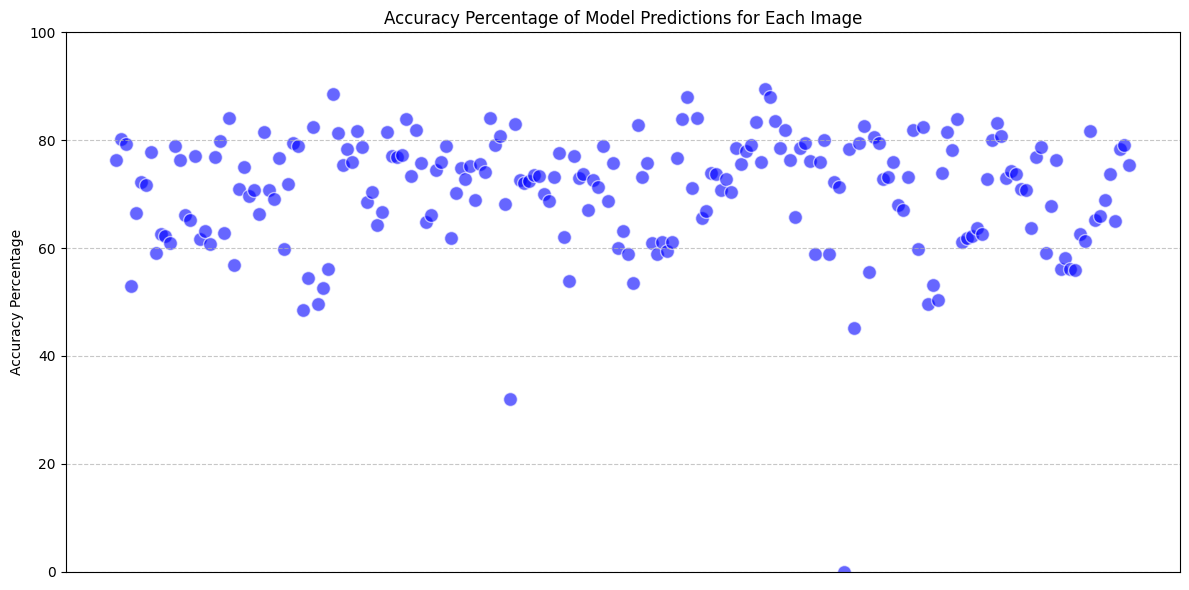

In [20]:
def plot_accuracy_scatter(results, show=True):
    """
    Plots a scatter diagram of the accuracy percentages for each image.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name and accuracy percentage.
        show (bool): If True, the plot will be shown. Default is True.
    """
    results.sort(key=lambda x: x[0])

    # Separar los nombres de las imágenes y los porcentajes de precisión
    image_names = [result[0] for result in results]
    accuracies = [result[1] for result in results]

    # Crear un diagrama de dispersión
    plt.figure(figsize=(12, 6))
    plt.scatter(image_names, accuracies, color='blue', alpha=0.6, edgecolors='w', s=100)
    plt.xticks([])  # Eliminar las etiquetas del eje x
    plt.ylabel('Accuracy Percentage')
    plt.title('Accuracy Percentage of Model Predictions for Each Image')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if show:
      plt.show()
    return plt


if 'results' in locals(): plot_accuracy_scatter(results)

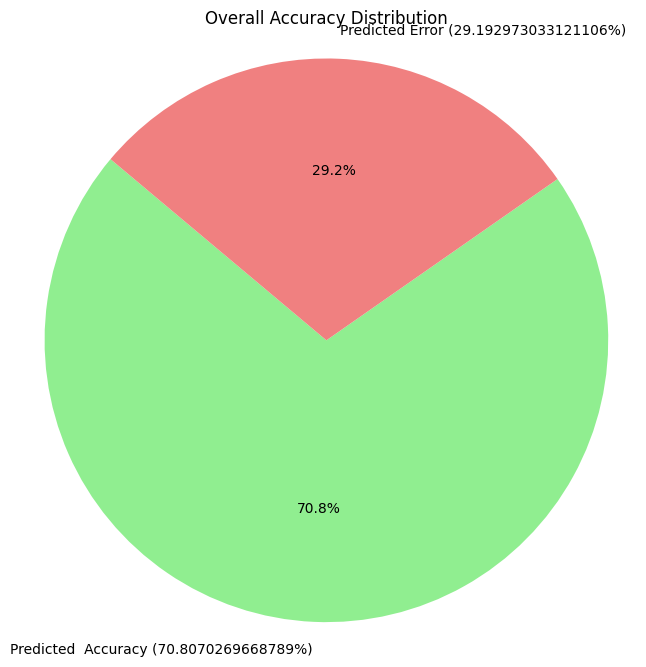

In [21]:
def plot_accuracy_pie(results, show=True):
    """
    Plots a pie chart showing the overall distribution of accuracy.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name and accuracy percentage.
        show (bool): If True, the plot will be shown. Default is True.
    """
    results.sort(key=lambda x: x[0])
    accuracies = [result[1] for result in results]

    # Calcular el promedio de las precisiones
    good_average_accuracy = sum(accuracies) / len(accuracies)
    bad_average_accuracy = 100 - good_average_accuracy

    labels = ['Predicted  Accuracy ({}%)'.format(good_average_accuracy), 'Predicted Error ({}%)'.format(bad_average_accuracy)]
    sizes = [good_average_accuracy, bad_average_accuracy]
    colors = ['lightgreen', 'lightcoral']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Overall Accuracy Distribution')
    if show:
      plt.show()
    return plt

if 'results' in locals(): plot_accuracy_pie(results)

#🪫Comparación entre modelos

In [22]:
def get_model(model_name):
    """
    Returns the model based on the model name.

    Parameters:
    model_name (str): The name of the model.

    Returns:
    nn.Module: The initialized model.
    """
    model_name = model_name.lower().split('_weights')[0]

    # Model initialization mapping
    model_mapping = {
        'deeplabv3': models.segmentation.deeplabv3_resnet50,
        'deeplabv3_resnet50': models.segmentation.deeplabv3_resnet50,
        'deeplabv3_resnet101': models.segmentation.deeplabv3_resnet101,
        'deeplabv3_mobilenet_v3_large': models.segmentation.deeplabv3_mobilenet_v3_large,
        'fcn': models.segmentation.fcn_resnet50,
        'fcn_resnet50': models.segmentation.fcn_resnet50,
        'fcn_resnet101': models.segmentation.fcn_resnet101,
        'lraspp': models.segmentation.lraspp_mobilenet_v3_large,
        'lraspp_mobilenet_v3_large': models.segmentation.lraspp_mobilenet_v3_large,
    }

    # Check for weights
    weights_mapping = {
        'deeplabv3': models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
        'deeplabv3_resnet50': models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
        'deeplabv3_resnet101': models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT,
        'deeplabv3_mobilenet_v3_large': models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
        'fcn': models.segmentation.FCN_ResNet50_Weights.DEFAULT,
        'fcn_resnet50': models.segmentation.FCN_ResNet50_Weights.DEFAULT,
        'fcn_resnet101': models.segmentation.FCN_ResNet101_Weights.DEFAULT,
        'lraspp': models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT,
        'lraspp_mobilenet_v3_large': models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT,
    }

    if model_name not in model_mapping:
        print(f"Depuración: Modelos disponibles - {list(model_mapping.keys())}")
        raise ValueError(f"Model {model_name} is not supported.")

    model_fn = model_mapping[model_name]
    weights = weights_mapping.get(model_name, None)

    # Return the model
    return model_fn(weights=weights)

In [23]:
def compare_models(available_models, data_df, csv_filename = "compare_models"):
    """
    Compares multiple segmentation models on the dataset.

    Parameters:
    available_models (list): A list of model names to evaluate.
    data_df (pd.DataFrame): The DataFrame containing image and point data.

    Returns:
    dict: A dictionary with model names as keys and evaluation results as values.
    """
    import time, csv
    csv_path = f"{output_folder}/{csv_filename}.csv"
    data_df = data_df.drop_duplicates()

    # Leer resultados existentes si el archivo ya existe
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path)
    else:
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            dfcolumns = ['model_name', 'image_name', 'accuracy_percentage', 'mean_distance', 'execution_time']
            writer.writerow(dfcolumns)
        existing_results = pd.DataFrame(columns=dfcolumns)

    model_results = {}

    for model_name in available_models:
        try:
            # Cargar modelo
            model = get_model(model_name)
            model.eval()
            print(f">>> Evaluating model: {model_name} in {len(data_df)} images")
            total_execution_time = 0
            local_result = []

            # Crear carpeta para el modelo si no existe
            model_output_folder = os.path.join(output_folder, model_name)
            if not os.path.exists(model_output_folder):
                os.makedirs(model_output_folder)

            # Filtrar imágenes ya evaluadas para el modelo actual
            if not existing_results.empty:
                evaluated_images = existing_results[existing_results['model_name'] == model_name]['image_name'].tolist()
                data_df_filtered = data_df[~data_df['IMAGE'].isin(evaluated_images)]
                print(f"Skipping {len(data_df) - len(data_df_filtered)} images already evaluated.")
            else:
                data_df_filtered = data_df




            # Leer y agregar resultados previos al diccionario model_results
            previous_results = existing_results[existing_results['model_name'] == model_name]
            for _, row in previous_results.iterrows():
                image_name = row['image_name']
                accuracy_percentage = row['accuracy_percentage']
                mean_distance = row['mean_distance']
                execution_time = row['execution_time']
                if model_name not in model_results:
                    model_results[model_name] = []
                model_results[model_name].append((image_name, accuracy_percentage, mean_distance, execution_time))






            if data_df_filtered.empty:
                print(f"Skipping {model_name}, all images already evaluated.")
                continue


            # Evaluar todas las imágenes 1 a 1 para guardar su resultado y poder reanudar
            i_counter = 0
            for idx, row in data_df_filtered.iterrows():
                image_name = row['IMAGE']
                point_value = row['POINT']
                i_counter += 1

                try:
                    start_time = time.time()

                    mean_distance, accuracy_percentage = evaluate_prediction(image_name, point_value, model, transform, image_folder, data_folder)
                    local_result.append((image_name, accuracy_percentage, mean_distance))
                    original_image, extracted_image = preprocess_image(image_name, model, transform)
                    save_image(extracted_image, f"{model_name}/{image_name}")

                    end_time = time.time()

                    execution_time = end_time - start_time
                    total_execution_time += execution_time

                    with open(csv_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow([model_name, image_name, accuracy_percentage, mean_distance, execution_time])

                    if model_name not in model_results:
                        model_results[model_name] = []
                    model_results[model_name] = [image_name, accuracy_percentage, mean_distance, execution_time]
                    print(f"[{i_counter}/{len(data_df_filtered)}] :: Model {model_name} - Image ID: {idx + 2} ({image_name}) evaluation completed in {execution_time:.2f} seconds.")

                except Exception as e:
                    print(f"Error evaluating image {image_name} with model {model_name}: {e}")

            # Guardar imágenes de las gráficas
            if local_result:
                plt1 = plot_accuracy_pie(local_result, show=False)
                plt1.savefig(f"{os.path.join(output_folder, model_name)}_pie.png")

                plt2 = plot_accuracy_scatter(local_result, show=False)
                plt2.savefig(f"{os.path.join(output_folder, model_name)}_scatter.png")

            print(f"🚩 Model {model_name} evaluation completed in {total_execution_time:.2f} seconds.")
        except AttributeError:
            print(f"Model {model_name} not found in torchvision.models.segmentation.")

    print("🎉 Finished ....")
    return model_results

In [24]:
import pandas as pd
data_df = pd.read_csv(tags_file)
transform = getTransform(image_folder)

In [25]:
# Run the comparison
if 'model' in locals(): del model
model_results = compare_models(available_models, data_df)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 105MB/s]


>>> Evaluating model: deeplabv3 in 207 images
Skipping 207 images already evaluated.
Skipping deeplabv3, all images already evaluated.


Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 106MB/s]


>>> Evaluating model: deeplabv3_mobilenet_v3_large in 207 images
Skipping 207 images already evaluated.
Skipping deeplabv3_mobilenet_v3_large, all images already evaluated.


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s]


>>> Evaluating model: deeplabv3_resnet101 in 207 images
Skipping 207 images already evaluated.
Skipping deeplabv3_resnet101, all images already evaluated.
>>> Evaluating model: deeplabv3_resnet50 in 207 images
Skipping 207 images already evaluated.
Skipping deeplabv3_resnet50, all images already evaluated.


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 92.0MB/s]


>>> Evaluating model: fcn in 207 images
Skipping 207 images already evaluated.
Skipping fcn, all images already evaluated.


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:03<00:00, 58.8MB/s]


>>> Evaluating model: fcn_resnet101 in 207 images
Skipping 207 images already evaluated.
Skipping fcn_resnet101, all images already evaluated.
>>> Evaluating model: fcn_resnet50 in 207 images
Skipping 207 images already evaluated.
Skipping fcn_resnet50, all images already evaluated.
>>> Evaluating model: lraspp in 207 images
Skipping 207 images already evaluated.
Skipping lraspp, all images already evaluated.
>>> Evaluating model: lraspp_mobilenet_v3_large in 207 images
Skipping 207 images already evaluated.
Skipping lraspp_mobilenet_v3_large, all images already evaluated.
🎉 Finished ....


# 📊 Gráficos de resultados

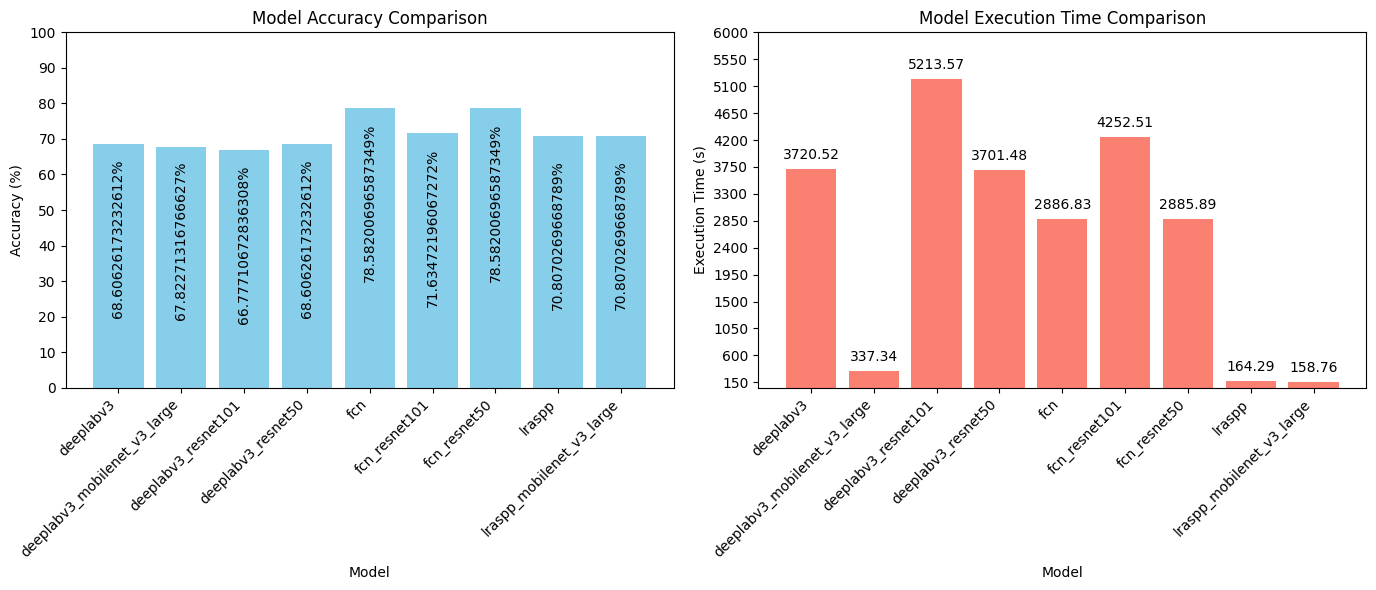

In [26]:
def plot_model_comparison(model_results):
    """
    Plots and save .png file of a comparison of model accuracies.

    Parameters:
    model_results (dict): A dictionary with model names as keys and evaluation results as values.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from statistics import mean

    df_results = pd.DataFrame({
        'Model': [model for model in model_results],
        'Accuracy (%)': [mean([result[1] for result in model_results[model]]) for model in available_models],
        'Execution Time (s)': [sum([result[3] for result in model_results[model]]) for model in available_models],
    })

    plt.figure(figsize=(14, 6))

    # Plot for Accuracy
    plt.subplot(1, 2, 1)
    bars = plt.bar(df_results['Model'], df_results['Accuracy (%)'], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(0, 101, 10))
    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval}%', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, -125),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=90)

    # Plot for Execution Time
    plt.subplot(1, 2, 2)
    bars = plt.bar(df_results['Model'], df_results['Execution Time (s)'], color='salmon')
    plt.xlabel('Model')
    plt.ylabel('Execution Time (s)')
    plt.title('Model Execution Time Comparison')
    plt.xticks(rotation=45, ha='right')

    min_time = min(df_results['Execution Time (s)'])
    max_time = max(df_results['Execution Time (s)'])

    # Ajustar estos parametros para mejor vision de las graficas
    ymin = min_time - 8
    ymax = max_time + 1001
    yminlim = min_time - 100
    ymaxlim = max_time + 1000
    ystep = 450

    plt.ylim(yminlim, max_time + 500)
    plt.yticks(range(int(ymin), int(ymax), ystep))

    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval:.2f}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    # plt.savefig(f"{output_folder}/model_comparison.png")
    plt.show()
plot_model_comparison(model_results)

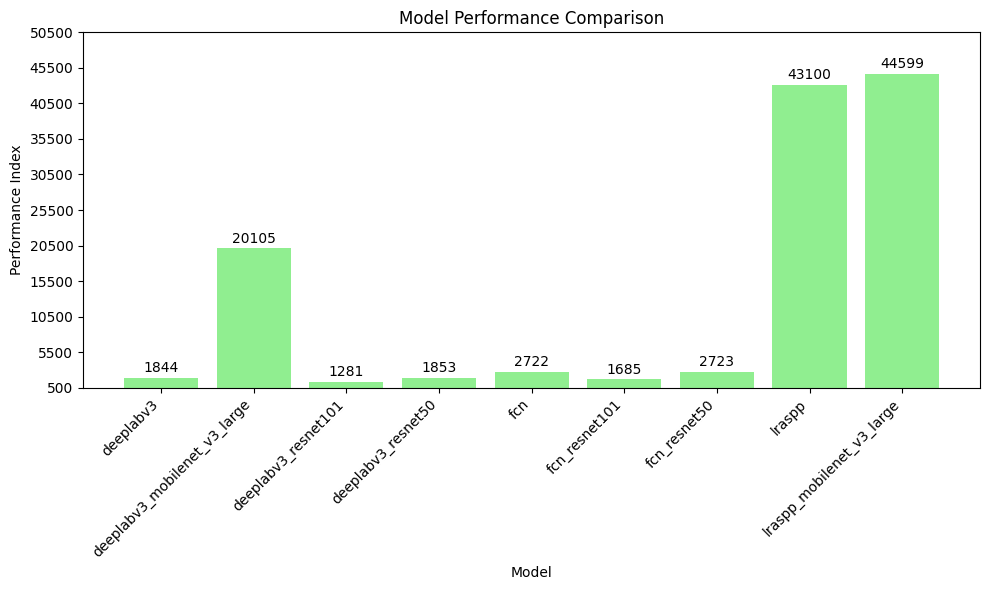

In [27]:
def plot_model_performance(model_results):
    """
    Plots and saves a .png file of a comparison of model performance based on accuracy and execution time.

    Parameters:
    model_results (dict): A dictionary with model names as keys and evaluation results as values.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from statistics import mean

    df_results = pd.DataFrame({
        'Model': [model for model in model_results],
        'Accuracy (%)': [mean([result[1] for result in model_results[model]]) for model in available_models],
        'Execution Time (s)': [sum([result[3] for result in model_results[model]]) for model in available_models],
    })

    # Calculate performance index (accuracy / execution time)
    df_results['Performance Index'] = (df_results['Accuracy (%)'] / df_results['Execution Time (s)']) * 100000
    df_results_sorted = df_results # .sort_values(by='Performance Index', ascending=False)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_results_sorted['Model'], df_results_sorted['Performance Index'], color='lightgreen')
    plt.xlabel('Model')
    plt.ylabel('Performance Index')
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45, ha='right')

    min_performance = df_results_sorted['Performance Index'].min()
    max_performance = df_results_sorted['Performance Index'].max()


  # Ajustar estos parametros para mejor vision de las graficas
    ymax = max_performance + 6299 + 1
    ymin = min_performance - 780
    yminlim = min_performance - 100
    ymaxlim = max_performance + 1000
    ystep = 5000

    plt.ylim(yminlim, ymaxlim)
    plt.yticks(range(int(ymin), int(ymax), ystep))
    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval:.0f}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, 2),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    # plt.savefig(f"{output_folder}/model_performance_mean.png")
    plt.show()

plot_model_performance(model_results)